In [1]:
import numpy as np
from particles.collectors import Moments
from sdes.feynman_kac import CDSSM_SMC, BootstrapDA, BootstrapReparameterisedDA, ForwardGuidedDA, ForwardReparameterisedDA, BackwardGuidedDA, BackwardReparameterisedDA
from sdes.auxiliary_bridges import MvDelyonHuAuxBridge, MvOUProposal, MvOUAuxBridge
import dill
import os
import matplotlib.pyplot as plt
import sdes.plot as splt

In [2]:
def make_plot(filt_smth_means, filt_smth_stds):
    """
    Plot used in the MV_OU_process_smoothing.ipynb notebook.
    Put here to make the notebook cleaner.
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    for l, title in enumerate(['filtering', 'smoothing']):
        for i in range(dimX):
            axes[l,i].plot(s, x_arr[i], label=f'$X_{i}(s)$ - Time inhomogeneous OU process')
            axes[l,i].plot(ts[1:], et_s[i], 'o', c='#1f77b4', markersize=5., label='$e_t$')
            axes[l,i].plot(ts[1:-1], y_arr[i, :-1], 'x', markersize=10., label='$y_t: \eta=0.4$')
            axes[l,i].plot(ts[-1:], y_arr[i, -1:],'x', markersize=10., c='r', label='$y_t: \eta=0.01$')
            axes[l,i].set_xlabel(r'$t$')
            axes[l,i].set_ylabel(ylabels[i])
            axes[l,i].set_title(f'{title} distribution: $x_{i+1}$')

            for j in range(T+1):
                axes[l,i].axvline(x=j, color='black', linestyle='--', alpha=0.3, linewidth=1)
            axes[l,i].set_xticks([k for k in range(T+1)])

            axes[l,i].plot(ts, filt_smth_means[l][i], c='g', alpha=0.3, label='mean $\mu_t$')
            axes[l,i].plot(ts, filt_smth_means[l][i] + 2*filt_smth_stds[l][i], '--', c='g', alpha=0.3, label='$\mu_t$ +/- 2$\sigma_t$')
            axes[l,i].plot(ts, filt_smth_means[l][i] - 2*filt_smth_stds[l][i], '--', c='g', alpha=0.3)


    fig.suptitle(f'Time-switching MvOU process with switching time at t={t_switch} and t={t_switchY}')
    plt.legend()
    return fig, axes

# Defining a Continuous-Discrete State Space Model

Consider the Ornstein-Uhlenbeck process in general d-dimensions:

$$dX(s) = -\rho X(s) ds + C(s) dB(s) \qquad X(0) = 0. \qquad (1)$$ 

Where, $\rho = (\rho_1, \dots, \rho_d)$ and $C(s): [0, S] \rightarrow \mathbb{R}^{d\times d}$ is a time inhomogeneous, state-independent diffusion coefficient.

This process is observed at $T$ discrete times $0<s_1 < s_2 < \dots < s_T=S$, with noise. So we are working with a continuous time set $\mathcal{S} = [0, S]$ and a discrete one $\mathcal{T} = \{1, \dots T\}$. We set $E_t = X(s_t)$

We assume that observation times are equidistant $s_t - s_{t-1} = \Delta_t = 1$, and we define each observation density $f_t(y_t|e_t)$ to be linear, Gaussian:

$$Y_t |E_t = e_t \sim \mathcal{N}_d(e_t, D(t)) \qquad (2)$$ 

Where $D(t): \mathcal{T} \rightarrow [0, \infty]$ is a map defining the observation noise level at each timestep.

As the OU process above is a linear SDE, it has a tractable transition density $p_t(e_t|e_{t-1})$, given by:

$$E_t|E_{t-1} = e_{t-1} \sim \mathcal{N}_d(\mu(e_{t-1}, \Sigma(e_{t-1})))$$

With $\mu(e_{t-1}) = e^{-\rho \Delta_t} e_{t-1}$, $\Sigma(e_{t-1}) = \int_{s_{t-1}}^{s_t}C^2(u)e^{2\rho u}du$

We now specify the functions $C(t)$ and $D(t)$ in a piecewise fashion, to be:

$$C(s) = \phi_1 \quad s \in [0, s_{t^*}], \quad C(s) = \phi_2 \quad s \in (s_{t^*}, s_T] \qquad (3)$$

$$D(t) = \eta_1 I_{d} \quad t \in \{1, \dots, t^{**}\}, \quad D(t) = \eta_2 I_{d} \quad t \in \{t^{**}+1, \dots, T\} (4)$$

Equation (1)-(4) fully defines a CD-SSM with parameters $\theta = (\rho, \phi_1, \phi_2, \eta_1, \eta_2, t^*, t^{**})$. 

We set $\phi_1 >> \phi_2$, meaning that up to $s_1$ the underlying diffusion is noiser for $s<s_{t^*}$. We set $\eta_1 >> \eta_2$, thus meaning that for the observations $t>{t^{**}}, $y_t$ is highly informative of the location of the latent process.

The random variables $(E_{1:T}, Y_{1:T})$ form a (time-inhomogeneous) linear, Gaussian state space model, and it is possible to derive analytically the filtering and smoothing distributions, through Kalman filtering and smoothing. One can also implement particle filters/smoothers on discrete space, without data augmentation, with the optimal proposal being analytically tractable. Finally, the data augmentation approaches outlined in the contribution can be used. In practice, the particles package does not have an implementation of the Kalman filter/smoother for the 

The `particles.kalman` package cannot implement kalman filtering/smoothing for time inhomogeneous state space models, so we find the benchmark filtering and smoothing distributions by instead using a particle filter with the optimal guided proposal, for a large number of particles.

The toy model above has been constructed so that the future observations are highly informative of the past: so for a reasonable choice of $\theta$ and $T$, we would find that $X_1 | Y_1$ would be a distribution with a higher variance than $X_1 | Y_{1:T}$. It is therefore an appropriate model with which to test smoothing algorithms.

# Load Results

In [3]:
filtering=True; smoothing=True; online_smoothing=True
remote = True

results_str = 'results' if not remote else 'results_remote'
cdssm_name = 'TimeSwitchingGaussianCDSSM'; sde_name = 'TS_MvOrnsteinUhlenbeck'

N=[20, 40, 80, 160, 320]; T=10; num=[10]; n_runs=50; i=10

def load_results(N, T, num, n_runs, i, objective):
    dir_name = f'/Users/chris_stanton/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/offline-smoothing-for-diffusions/scripts/{results_str}/{objective}/{cdssm_name}/{sde_name}'
    os.chdir(dir_name)

    filename = f'results_N={N}_T={T}_num={num}_n_runs={n_runs}_{i}.pkl'
    # Unpickle (deserialize) the object using dill
    with open(filename, 'rb') as f:
        results_dict = dill.load(f)
    
    return results_dict

if filtering:
    full_filtering_results = load_results(N, T, num, n_runs, i, 'filtering')
if smoothing:
    full_smoothing_results = load_results(N, T, num, n_runs, i,'smoothing')
if online_smoothing:
    full_osmoothing_results = load_results(N, T, num, n_runs, i,'online_smoothing')

In [4]:
# Unpack the filtering results

filter_benchmark = full_filtering_results['benchmark_results'][0]['output'] # pf.summaries
multiSMC_results = full_filtering_results['multiSMC_results']
multicdssm_SMC_results = full_filtering_results['multiCDSSM_SMC_results']
filtering_results = multiSMC_results + multicdssm_SMC_results

cdssm = full_filtering_results['cdssm']
sde = cdssm.model_sde
x, y = full_filtering_results['x'], full_filtering_results['y']

# Unpack the smoothing results

smoother_benchmark = full_smoothing_results['benchmark_results'][0]['ests'] # dict of arrays
smc_smth_results = full_smoothing_results['multiSMC_results']
cdssm_smc_smth_results = full_smoothing_results['multiCDSSM_SMC_results']
smoothing_results = smc_smth_results + cdssm_smc_smth_results

x_smth, y_smth = full_smoothing_results['x'], full_smoothing_results['y']

# Verify that the data for the filtering and smoothing results is the same. 
assert np.all(np.isclose(np.concatenate([y_val for y_val in y], axis=0), np.concatenate([y_val for y_val in y_smth], axis=0)))

# Unpack the online smoothing results

osmoother_benchmark = full_osmoothing_results['benchmark_results'][0]['ests'] # dict of arrays
smc_osmth_results = full_osmoothing_results['multiSMC_results']
cdssm_smc_osmth_results = full_osmoothing_results['multiCDSSM_SMC_results']
osmoothing_results = smc_osmth_results + cdssm_smc_osmth_results

x_smth, y_smth = full_osmoothing_results['x'], full_osmoothing_results['y']

# Verify that the data for the filtering and online smoothing results is the same. 
# assert np.all(np.isclose(np.concatenate([y_val for y_val in y], axis=0), np.concatenate([y_val for y_val in y_smth], axis=0)))

# Extract the ending points 
idx = x[0].dtype.names[-1]
et_s = np.concatenate([x_path[idx] for x_path in x], axis=0).T # (dimX, T)

In [5]:
filt_moms = filter_benchmark.moments
x0 = cdssm.x0; dimX = sde.dimX

# Filtering moments
filt_means = np.stack([x0.ravel()] + [filt_mom['mean'] for filt_mom in filt_moms], axis=1) # (dimX, T+1)
filt_stds = np.sqrt(np.stack([x0.ravel()] + [filt_mom['var'] for filt_mom in filt_moms], axis=1))  # (dimX, T+1)
filt_logLts = np.array(filter_benchmark.logLts) # (T,)

# Smoothing moments
smth_means = np.concatenate([x0, smoother_benchmark['phi_x']], axis=0).T # (dimX, T+1)
smth_vars = np.concatenate([np.zeros((1, dimX)), smoother_benchmark['phi_x_x'] - smoother_benchmark['phi_x']**2], axis=0).T # (dimX, T+1)
smth_stds = np.sqrt(smth_vars)

# Plot of the dataset and the true distribution

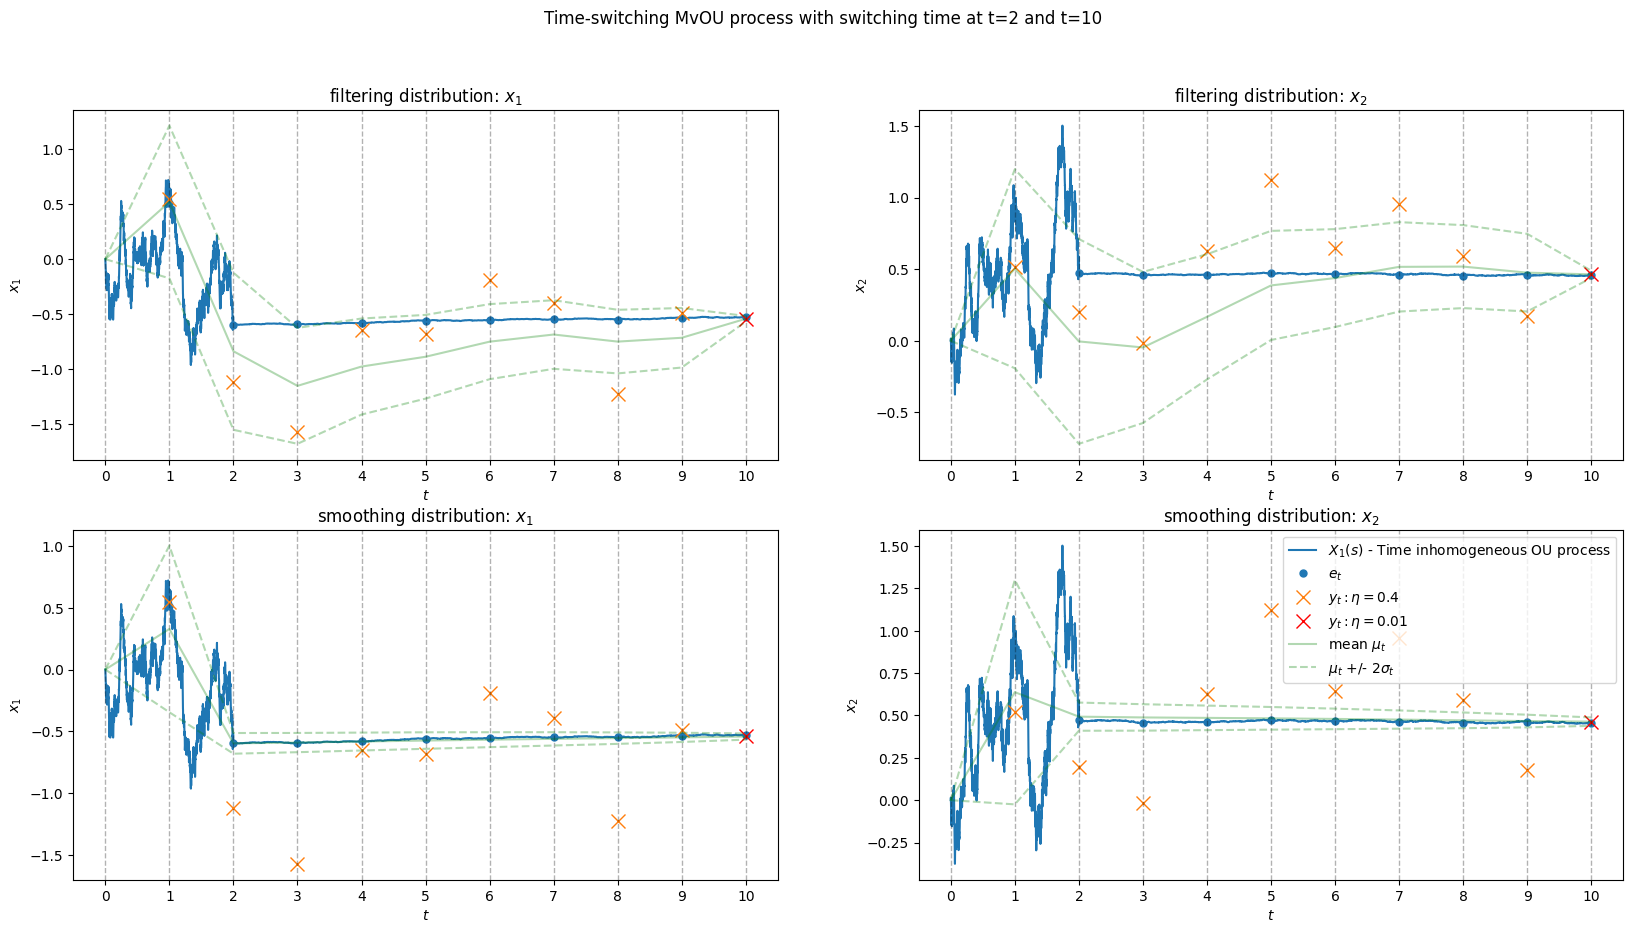

In [6]:
delta_s = cdssm.delta_s; s_T = T*delta_s; x0 = cdssm.x0
t_switch = cdssm.t_switch; t_switchY = cdssm.t_switchY
dimX = cdssm.model_sde.dimX

s = np.linspace(0, s_T, num=T*1000+1) # (T*1000+1,)
ts = np.arange(0, T+1, dtype=np.float64)*delta_s # (T+1,)
sa_to_arr = lambda x: np.concatenate([x[name] for name in x.dtype.names], axis=0) # (num, dimX)
x_arr = np.concatenate([x0] + [sa_to_arr(x_t) for x_t in x], axis=0).T # (dimX, 1 + T*num)
y_arr = np.concatenate([y_t for y_t in y]).T # (dimX, T)
ylabels = [r'$x_1$', r'$x_2$']

filt_smth_means = [filt_means, smth_means]; filt_smth_stds = [filt_stds, smth_stds]
make_plot(filt_smth_means, filt_smth_stds)
plt.show()

## Aims 

- For `BootstrapReparameterised` models, we aim to show that filtering performance is similar to the bootstrap, and smoothing performance may be improved by the choice of the bridge that we use for the transform.  
- For `MvForwardProposal` models, we aim to show that guided proposals that are based on a linear SDE that is closer to the true process perform better than more naive choices, and that strong filtering performance translates into strong smoothing performance.
    - It is hard to assess the impact of auxiliary bridge choice on the smoothing, as we want the auxiliary bridge to match the bridge of the Forward proposal, which is in general a time-inhomogeneous SDE.
- For `BackwardReparameterised` models, we aim to show that:
    - When the `OU` bridge is used, the algorithm effectively becomes a standard guided proposal particle filter.
    - When the `OUP` is used to propose the end point, this is the optimal proposal for the end point.
    - Backward proposals cannot be used to test whether the choice of auxiliary bridge improves the smoothing. This is because the choice of bridge is component of the filtering proposal. Thus, the choice of bridge affects the filtering, which will also affect the smoothing.




In [7]:
results_FFBS_ON2 = [r for r in smoothing_results if r['method'] == 'FFBS_ON2']
results_FFBS_MCMC = [r for r in smoothing_results if r['method'] == 'FFBS_MCMC']

results_add_naive = [r for r in osmoothing_results if r['col'] == 'MultiOnline_smooth_naive']
results_add_0N2 = [r for r in osmoothing_results if r['col'] == 'MultiOnline_smooth_ON2']
results_add_mcmc = [r for r in osmoothing_results if r['col'] == 'MultiOnline_smooth_mcmc']


benchmark_pfs = ['bootstrap', 'guided']

all_fk_names = list(set([r['fk'] for r in cdssm_smc_smth_results]))
# fk_names = benchmark_pfs + all_fk_names[:-50]
fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('BsR')]
# fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('FwG')]
# fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('FwR')]
# fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('FwR_DH')]
# fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('FwR_OU')]
# fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('FwR_DBr')]
# fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('FwR_DBr') or fk.startswith('FwR_DH')]

# fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('BwR')]
# fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('BwR_OU')]
# fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('BwR_DH')]
# fk_names = benchmark_pfs + [fk for fk in all_fk_names if fk.startswith('BwR_DBr')]

fk_names = ['bootstrap', 'BsR_DH', 'guided', 'BwR_OU_OUP', 'BwR_DH_OUP', 'BwR_DH_IOUP', 'FwR_DH_OUP', 'FwR_DH_DBrP', 'FwR_DH_NDBBrP']

# MSE Plots

We can use the MSE plots to help us to identify boxplots that may be of interest.

In [10]:
filtering_results = [r for r in filtering_results if r['N'] == 320]

## Filtering MSEs $X_t|Y_{1:t}$

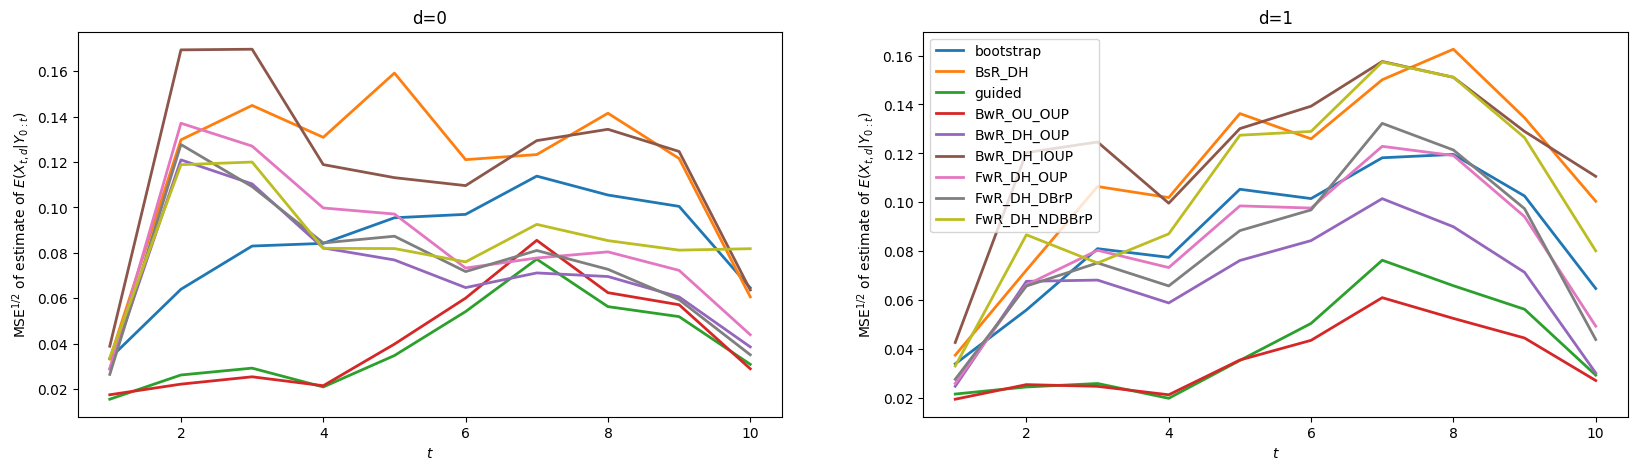

In [11]:
def filt_get_phi_x(r):
    return np.stack([mom['mean'] for mom in r['output'].moments], axis=1) # (dimX, T)

fig, axes = splt.mse_plot(filtering_results, fk_names, filt_means[:, 1:], filt_get_phi_x)
for i, ax in enumerate(axes):
    ax.set_ylabel(r'MSE$^{1/2}$ of estimate of $E(X_{t, d}|Y_{0:t})$')
    ax.set_title(f'd={i}')

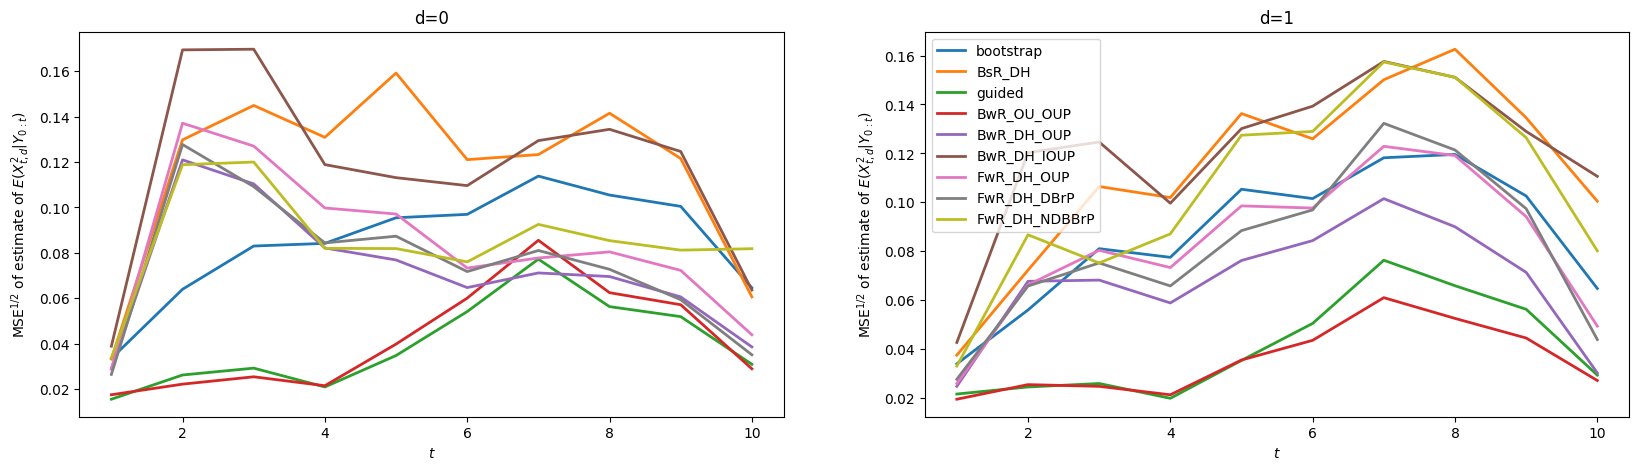

In [12]:
def filt_get_phi_phi_x(r):
    return np.stack([mom['mean'] for mom in r['output'].moments], axis=1) # (dimX, T)

fig, axes = splt.mse_plot(filtering_results, fk_names, filt_means[:, 1:], filt_get_phi_x)
for i, ax in enumerate(axes):
    ax.set_ylabel(r'MSE$^{1/2}$ of estimate of $E(X_{t, d}^2|Y_{0:t})$')
    ax.set_title(f'd={i}')

## Filtering MSEs: $\log(p(y_{0:t}))$

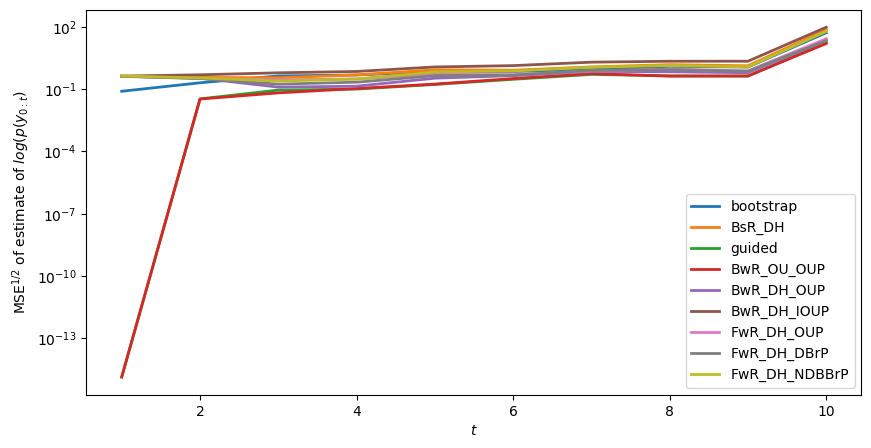

In [13]:
def get_logLt(r):
    return np.array(r['output'].logLts) # (T, )

fig, axes = splt.mse_plot(filtering_results, fk_names, filt_logLts, get_logLt)
axes.set_ylabel(r'MSE$^{1/2}$ of estimate of $log(p(y_{0:t})$')
axes.set_yscale('log')
plt.show()

## Offline Smoothing MSEs - FFBS-MCMC $X_t|Y_{1:T}$

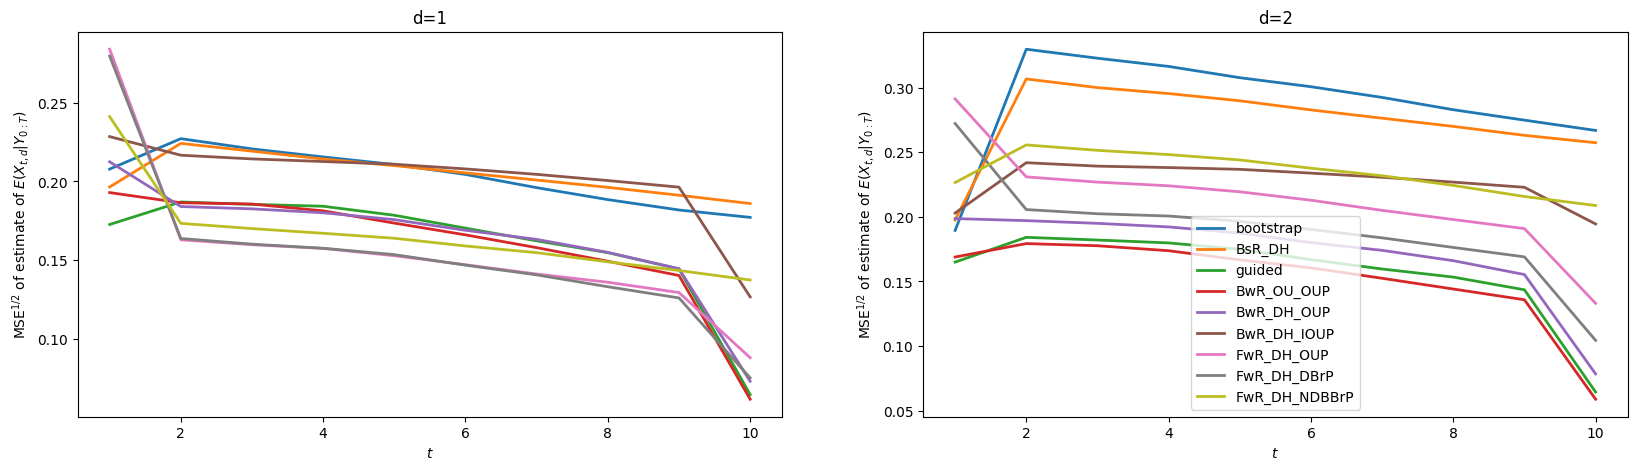

In [14]:
def smth_get_phi_x(r):
    return r['ests']['phi_x'].T # (dimX, T)

fig, axes = splt.mse_plot(results_FFBS_MCMC, fk_names, smth_means[:, 1:], smth_get_phi_x)
for i, ax in enumerate(axes):
    ax.set_ylabel(r'MSE$^{1/2}$ of estimate of $E(X_{t, d}|Y_{0:T})$')
    ax.set_title(f'd={i+1}')

## Offline Smoothing MSEs - FFBS-MCMC $X^2_t|Y_{1:T}$

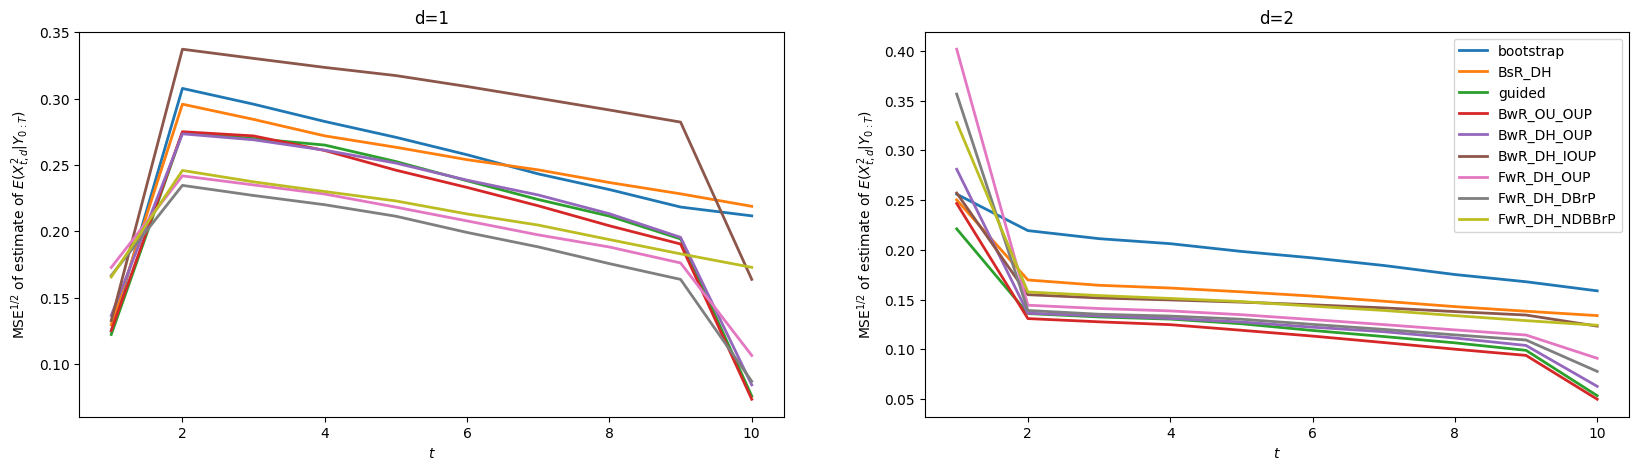

In [15]:
def smth_get_phi_x_x(r):
    return r['ests']['phi_x_x'].T # (dimX, T)

fig, axes = splt.mse_plot(results_FFBS_MCMC, fk_names, smth_vars[:, 1:] + smth_means[:, 1:] ** 2, smth_get_phi_x_x)
for i, ax in enumerate(axes):
    ax.set_ylabel(r'MSE$^{1/2}$ of estimate of $E(X^2_{t, d}|Y_{0:T})$')
    ax.set_title(f'd={i+1}')

## Offline Smoothing MSEs - FFBS $O(N^2)$

In [14]:
# fig, ax = splt.mse_plot(results_FFBS_ON2, fk_names, smth_means, smoothing=True)
# plt.show()

## Online Smoothing MSEs - Geneaology Tracking

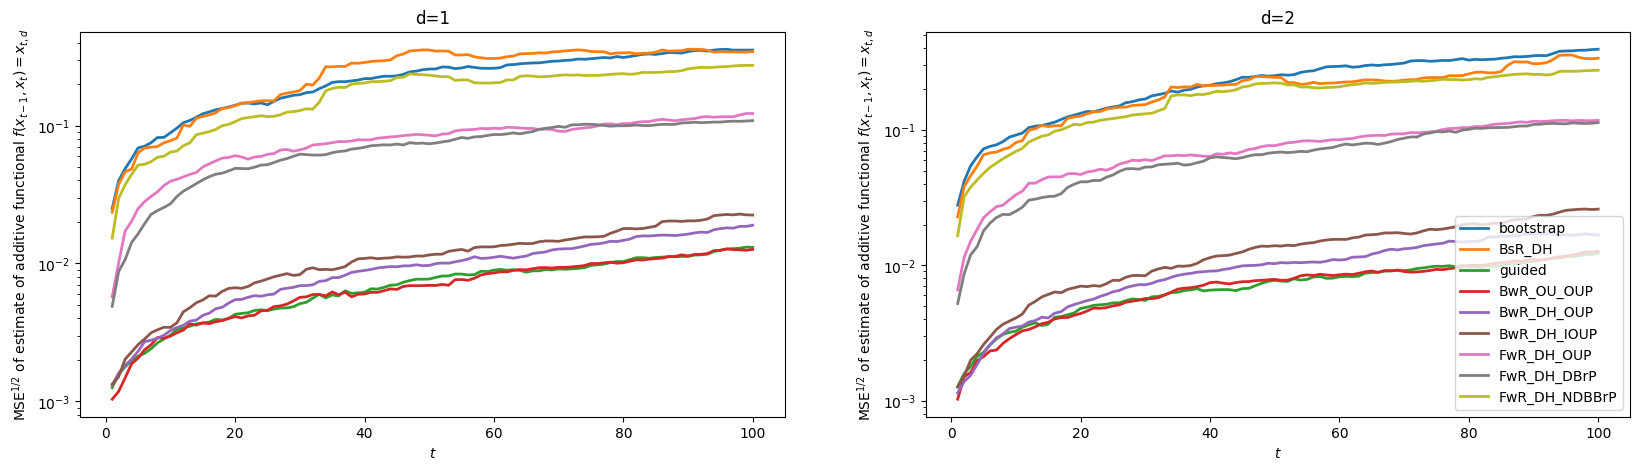

In [15]:
def osmth_get_phi_x(r):
    ests = getattr(r['output'], 'multiOnline_smooth_naive')
    return np.stack([est['phi_x'] for est in ests], axis=1) # (dimX, T)

fig, axes = splt.mse_plot(results_add_naive, fk_names, osmoother_benchmark['phi_x'].T, osmth_get_phi_x)

for i, ax in enumerate(axes):
    ax.set_ylabel(r'MSE$^{1/2}$ of estimate of additive functional $f(x_{t-1}, x_{t}) = x_{t, d}$')
    ax.set_title(f'd={i+1}')
    ax.set_yscale('log')

## Online Smoothing MSEs - Forward Additive-$\mathcal{O}(N^2)$ 

In [16]:
# def osmth_get_phi_x(r):
#     ests = getattr(r['output'], 'multiOnline_smooth_ON2')
#     return np.stack([est['phi_x'] for est in ests], axis=1) # (dimX, T)

# fig, axes = splt.mse_plot(results_add_mcmc, fk_names, osmoother_benchmark['phi_x'].T, osmth_get_phi_x)

# for i, ax in enumerate(axes):
#     ax.set_ylabel(r'MSE$^{1/2}$ of estimate of additive functional $f(x_{t-1}, x_{t}) = x_{t, d}$')
#     ax.set_title(f'd={i+1}')

## Online Smoothing MSEs - Forward Additive-MCMC 

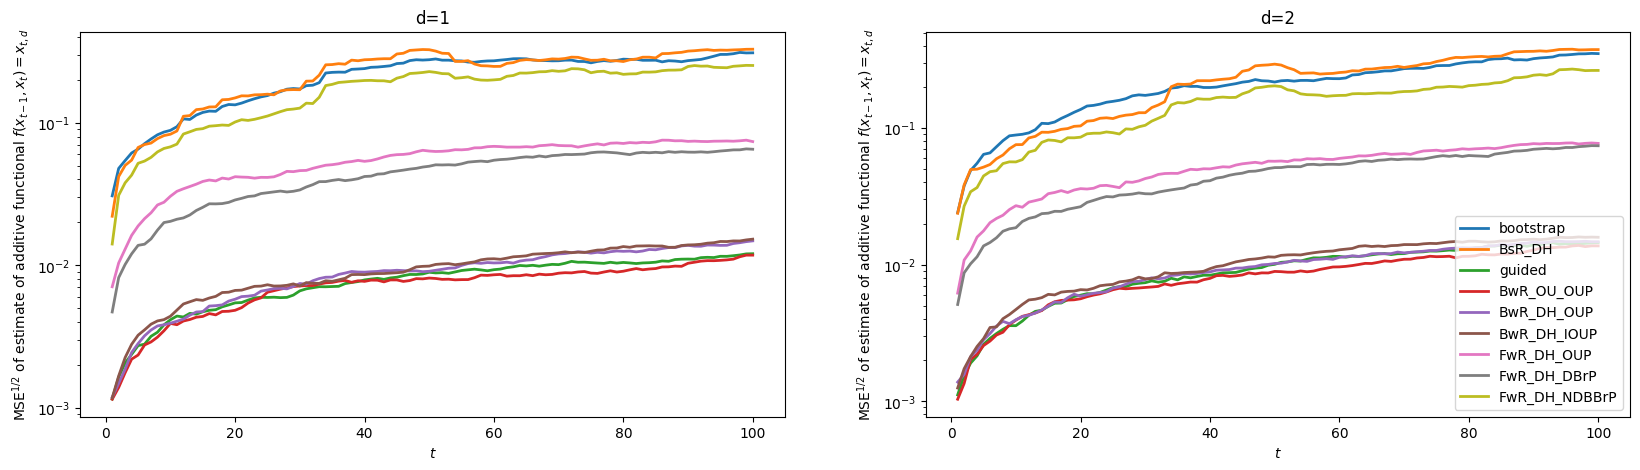

In [17]:
def osmth_get_phi_x(r):
    ests = getattr(r['output'], 'multiOnline_smooth_mcmc')
    return np.stack([est['phi_x'] for est in ests], axis=1) # (dimX, T)

fig, axes = splt.mse_plot(results_add_mcmc, fk_names, osmoother_benchmark['phi_x'].T, osmth_get_phi_x)

for i, ax in enumerate(axes):
    ax.set_ylabel(r'MSE$^{1/2}$ of estimate of additive functional $f(x_{t-1}, x_{t}) = x_{t, d}$')
    ax.set_title(f'd={i+1}')
    ax.set_yscale('log')

# Filtering ESS Plot

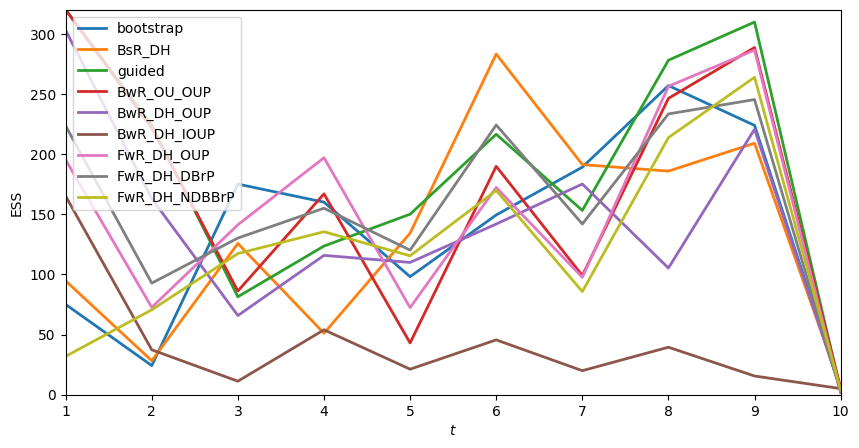

In [16]:
fig, axes = splt.ess_plot(filtering_results, fk_names)
fig.set_size_inches(10, 5)
plt.show()

# Filtering Boxplots 

### CPU Times

In [19]:
# fig, axes = splt.boxplots(filtering_results, [splt.filt_cpu_time], fk_names)
# fig.set_size_inches(20, 5)
# plt.show()

### LogLts

In [20]:
# times = [0, 1, 2, 8, 9]
# logLts = np.array(benchmark_filter.summaries.logLts)
# fig, axes = splt.boxplots(filtering_results, splt.gen_logLt_funcs(times), fk_names, true_values=logLts[times])
# fig.set_size_inches(20, 15)
# plt.show()

### Filtering Means

In [21]:
# filt_mean_mom_funcs = splt.gen_mom_funcs(splt.filt_mean, times, dimX=2)
# fig, axes = splt.boxplots(filtering_results, filt_mean_mom_funcs[0], fk_names, true_values=filt_means[:, 1:][0, times])
# fig.set_size_inches(25, 15)
# plt.show()

In [22]:
# fig, axes = splt.boxplots(filtering_results, filt_mean_mom_funcs[1], fk_names, true_values=filt_means[:, 1:][1, times])
# fig.set_size_inches(25, 15)
# plt.show()

<!-- # Offline Smoothing Boxplots -->

<!-- ## Boxplots: FFBS MCMC -->

<!-- ### CPU Times -->

In [23]:
# times = [1, 2, 8]
# fig, axes = splt.boxplots(results_FFBS_MCMC, [splt.smth_cpu_time], fk_names)
# fig.set_size_inches(20, 5)
# plt.show()

<!-- ### Smoothing Means  -->

In [24]:
# smth_mean_mom_funcs = splt.gen_mom_funcs(splt.smth_mean, times, dimX=2)
# fig, axes = splt.boxplots(results_FFBS_MCMC, smth_mean_mom_funcs[0], fk_names, true_values=smth_means[:, 1:][0, times])
# fig.set_size_inches(15, 15)
# plt.show()

In [25]:
# fig, axes = splt.boxplots(results_FFBS_MCMC, smth_mean_mom_funcs[1], fk_names, true_values=smth_means[:, 1:][1, times])
# fig.set_size_inches(15, 15)
# # plt.show()

## Boxplots - FFBS $\mathcal{O}(N^2)$

### CPU Times

In [26]:
# times = [0, 4, 8]
# fig, axes = splt.boxplots(results_FFBS_ON2, [splt.smth_cpu_time], fk_names)
# fig.set_size_inches(15, 5)
# plt.show()

### Smoothing means

In [27]:
# # times = [0, 4, -1]
# smth_mean_mom_funcs = splt.gen_mom_funcs(splt.smth_mean, times, dimX=2)
# fig, axes = splt.boxplots(results_FFBS_ON2, smth_mean_mom_funcs[0], fk_names, true_values=smth_means[:, 1:][0, times])
# fig.set_size_inches(20, 15)
# plt.show()

In [28]:
# # times = [0, 4, -1]
# smth_mean_mom_funcs = splt.gen_mom_funcs(splt.smth_mean, times, dimX=2)
# fig, axes = splt.boxplots(results_FFBS_ON2, smth_mean_mom_funcs[1], fk_names, true_values=smth_means[:, 1:][1, times])
# fig.set_size_inches(20, 15)
# plt.show()

# Plot of the results from a single particle filter/smoother run:

In [29]:
# from sdes.auxiliary_bridges import MvLLOUAuxBridge

# # Run a single CDSSM SMC to get the backward samples
# cdssm_smc_options = {'N': 100, 'store_history': True, 'num': 10, 'collect': [Moments]}

# fk_cls = ForwardReparameterisedDA

# if fk_cls is BackwardReparameterisedDA:
#     cdssm_fk_options = {'cdssm': cdssm, 'data': y, 'end_pt_proposal_sde_cls': MvOUProposal, 'auxiliary_bridge_cls': MvDelyonHuAuxBridge}
# if fk_cls is ForwardReparameterisedDA:
#     cdssm_fk_options = {'cdssm': cdssm, 'data': y, 'proposal_sde_cls': MvOUProposal, 'auxiliary_bridge_cls': MvDelyonHuAuxBridge}

# fk = fk_cls(**cdssm_fk_options)

# cdssm_smc = CDSSM_SMC(fk, **cdssm_smc_options)
# cdssm_smc.run()

# cd_backward_samples = cdssm_smc.hist.backward_sampling_mcmc(cdssm_smc.N)

In [30]:
# cd_filt_moms = cdssm_smc.summaries.moments

# # Could put zeros on the front?
# cd_filt_means = np.stack([x0.ravel()] + [filt_mom['mean'] for filt_mom in cd_filt_moms], axis=1) # (dimX, T)
# cd_filt_stds = np.sqrt(np.stack([x0.ravel()] + [filt_mom['var'] for filt_mom in cd_filt_moms], axis=1))  # (dimX, T)

# # Smoothing dists
# cd_smth_means = np.stack([x0.ravel()] + [bw_s[idx].mean(axis=0) for bw_s in cd_backward_samples], axis=1) # (dimX, T)
# cd_smth_stds = np.stack([x0.ravel()] + [bw_s[idx].std(axis=0) for bw_s in cd_backward_samples], axis=1) # (dimX, T)

# cd_fs_means = [cd_filt_means, cd_smth_means]; cd_fs_stds = [cd_filt_stds, cd_smth_stds]
# fig, ax = make_plot(cd_fs_means, cd_fs_stds)
# plt.show()